In [516]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.optim import Adam

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seed
torch.manual_seed(44)
np.random.seed(44)


class VanGenuchten:
    def __init__(self, theta_s, theta_r, alpha, n, Ks, l):
        self.theta_s, self.theta_r = theta_s, theta_r
        self.alpha, self.n, self.m = alpha, n, 1.0 - 1.0 / n
        self.Ks, self.l = Ks, l
        self._tiny = 1e-12  # minimal guard

    def theta(self, h):
        abs_h = torch.abs(h)
        denom = (1.0 + (self.alpha * abs_h).pow(self.n)).pow(self.m)
        denom = denom + self._tiny  # avoid 0
        theta_unsat = self.theta_r + (self.theta_s - self.theta_r) / denom
        return torch.where(
            h >= 0.0,
            torch.as_tensor(self.theta_s, device=h.device, dtype=h.dtype),
            theta_unsat,
        )

    def Se(self, h):
        th = self.theta(h)
        Se = (th - self.theta_r) / (self.theta_s - self.theta_r + self._tiny)
        # keep in (0,1) to avoid fractional-power NaNs
        return torch.clamp(Se, 1e-6, 1.0 - 1e-6)

    def K(self, h):
        Se = self.Se(h)
        Se_1m = Se.pow(1.0 / self.m)
        K_unsat = self.Ks * (Se.pow(self.l)) * (1.0 - (1.0 - Se_1m).pow(self.m)).pow(2)
        return torch.where(
            h >= 0.0,
            torch.as_tensor(self.Ks, device=h.device, dtype=h.dtype),
            torch.clamp(K_unsat, 0.0, self.Ks),
        )  # keep nonnegative & ≤ Ks


class PressureHeadNet(nn.Module):
    """Neural network for pressure head h(z,t)"""

    def __init__(self, hidden_dim, num_layers, t_max, z_norm_val=3.0):
        super().__init__()

        # Store normalization parameters
        self.t_max = t_max
        self.z_norm_val = z_norm_val  # Maximum depth for normalization (positive value)

        layers = []
        layers.append(nn.Linear(2, hidden_dim))
        layers.append(nn.Tanh())

        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.Tanh())

        layers.append(nn.Linear(hidden_dim, 1))

        self.net = nn.Sequential(*layers)

    def forward(self, z, t):
        # Normalize time input from [0, t_max] to [0, 1]
        t_normalized = t / self.t_max
        
        # Normalize spatial input from [-z_norm_val, 0] to [0, 1]
        # z ranges from -zb(t) to 0, so we normalize by z_norm_val (maximum expected depth)
        z_normalized = (z + self.z_norm_val) / self.z_norm_val  # maps [-z_norm_val, 0] to [0, 1]
        
        inputs = torch.cat([z_normalized, t_normalized], dim=1)
        h = self.net(inputs)
        # Constrain pressure head to reasonable range
        # return torch.clamp(h, -50.0, 5.0)
        return h


class WaterTableNet(nn.Module):
    """Neural network for water table depth z_b(t) with z_b > 0"""

    def __init__(self, hidden_dim, num_layers, t_max, eps=1e-3):
        super().__init__()

        # Store time normalization parameter
        self.t_max = t_max

        layers = [nn.Linear(1, hidden_dim), nn.Tanh()]
        for _ in range(num_layers - 1):
            layers += [nn.Linear(hidden_dim, hidden_dim), nn.Tanh()]
        layers += [nn.Linear(hidden_dim, 1)]
        self.net = nn.Sequential(*layers)
        # self.eps = eps  # small positive to avoid exactly zero

    def forward(self, t):
        # Normalize time input from [0, t_max] to [0, 1]
        t_normalized = t / self.t_max
        raw = self.net(t_normalized)
        zb = F.softplus(raw)  # ensures zb > 0 smoothly
        return zb


class RichardsPINN(nn.Module):
    """PINN for Richards equation with moving boundary"""

    def __init__(
        self,
        soil_params,
        q0_data,
        Sy,
        zr,
        h_net_config,
        zb_net_config,
        zb_initial=1.5,
        t_max=86400.0,
        z_norm_val=5.0,
    ):
        super().__init__()
        self.h_net = PressureHeadNet(
            h_net_config["hidden_dim"], h_net_config["num_layers"], t_max=t_max, z_norm_val=z_norm_val
        )
        self.zb_net = WaterTableNet(
            zb_net_config["hidden_dim"], zb_net_config["num_layers"], t_max=t_max
        )
        self.soil = VanGenuchten(**soil_params)
        self.Sy = torch.tensor(Sy, device=device)
        self.zr = zr  # Make this configurable instead of hardcoded 0.5
        self.zb_initial = zb_initial  # Initial water table depth
        self.q0_times = torch.tensor(q0_data[0], dtype=torch.float32, device=device)
        self.q0_values = torch.tensor(q0_data[1], dtype=torch.float32, device=device)

    def forward(self, z, t):
        """Return h(z,t) and z_b(t)"""
        h = self.h_net(z, t)
        zb = self.zb_net(t)
        return h, zb

    def surface_flux(self, t):
        """Prescribed surface flux q0(t) - interpolated from input data"""
        # Interpolate from provided data
        # Simple linear interpolation using torch operations
        t_flat = t.flatten()
        q0_interp = torch.zeros_like(t_flat)

        for i in range(len(t_flat)):
            t_val = t_flat[i]
            # Find surrounding points for interpolation
            if t_val <= self.q0_times[0]:
                q0_interp[i] = self.q0_values[0]
            elif t_val >= self.q0_times[-1]:
                q0_interp[i] = self.q0_values[-1]
            else:
                # Linear interpolation
                idx = torch.searchsorted(self.q0_times, t_val)
                if idx == 0:
                    q0_interp[i] = self.q0_values[0]
                else:
                    t1, t2 = self.q0_times[idx - 1], self.q0_times[idx]
                    q1, q2 = self.q0_values[idx - 1], self.q0_values[idx]
                    alpha = (t_val - t1) / (t2 - t1)
                    q0_interp[i] = q1 + alpha * (q2 - q1)

        return q0_interp.reshape_as(t)

    # Root uptake can be modified to include more complex root uptake functions
    def root_uptake(self, z, t):
        """Simple root uptake S(z,t) in the root zone"""
        S_max = 1e-7
        return torch.where(
            z >= -self.zr, torch.full_like(z, S_max), torch.zeros_like(z)
        )

    def compute_derivatives(self, h, z, t):
        """Raw autograd derivatives (no clipping)"""
        theta_h = self.soil.theta(h)
        dtheta_dt = torch.autograd.grad(theta_h.sum(), t, create_graph=True)[0]
        dh_dz = torch.autograd.grad(h.sum(), z, create_graph=True)[0]
        K_h = self.soil.K(h)
        q = -K_h * (dh_dz + 1.0)
        dq_dz = torch.autograd.grad(q.sum(), z, create_graph=True)[0]
        return dtheta_dt, dq_dz, q, K_h

    def pde_residual(self, z, t):
        """Richards equation: ∂θ/∂t = -∂q/∂z - S"""
        z = z.requires_grad_(True)
        t = t.requires_grad_(True)
        h, _ = self(z, t)
        dtheta_dt, dq_dz, _, _ = self.compute_derivatives(h, z, t)
        S = self.root_uptake(z, t)
        return dtheta_dt + dq_dz + S

    def surface_bc_residual(self, t):
        """Flux BC at z=0: q(0,t) = q0(t)"""
        t = t.requires_grad_(True)
        z0 = torch.zeros_like(t, requires_grad=True, device=t.device)
        h0, _ = self(z0, t)
        K0 = self.soil.K(h0)
        dh_dz_0 = torch.autograd.grad(h0.sum(), z0, create_graph=True)[0]
        q_surf = -K0 * (dh_dz_0 + 1.0)
        q0 = self.surface_flux(t)
        return q_surf - q0

    def water_table_head_residual(self, t):
        """Head BC at WT: h(-z_b(t), t) = 0"""
        z_dummy = torch.zeros_like(t)
        _, zb = self(z_dummy, t)
        h_wt, _ = self(-zb, t)
        return h_wt

    def water_table_kinematic_residual(self, t):
        """WT kinematic: dz_b/dt = -q(-z_b,t)/S_y"""
        t = t.requires_grad_(True)
        _, zb = self(torch.zeros_like(t), t)
        dzb_dt = torch.autograd.grad(zb.sum(), t, create_graph=True)[0]
        z_wt = (-zb).requires_grad_(True)
        h_wt, _ = self(z_wt, t)
        K_wt = self.soil.K(h_wt)
        dh_dz_wt = torch.autograd.grad(h_wt.sum(), z_wt, create_graph=True)[0]
        q_wt = -K_wt * (dh_dz_wt + 1.0)
        return dzb_dt - q_wt / self.Sy

    def initial_conditions_residual(self, z, t0):
        """IC: hydrostatic guess h(z,t0)=z+z_b(t0), and z_b(t0)=zb_initial"""
        h, zb = self(z, t0)
        h_ic = -1 - z / zb
        zb_ic = torch.tensor(self.zb_initial, device=z.device).expand_as(zb)
        return (h - h_ic), (zb - zb_ic)

Using device: cpu


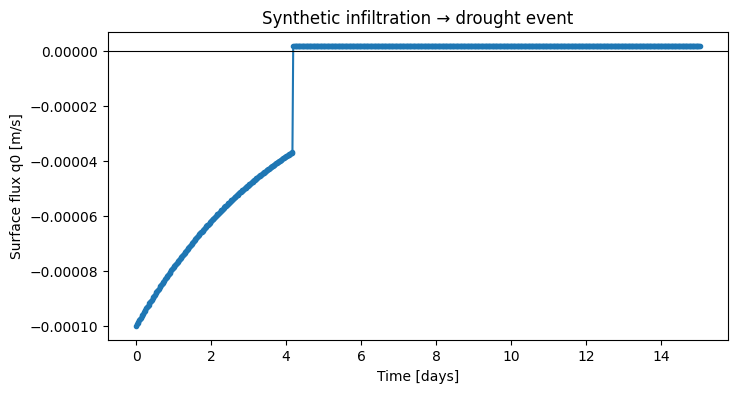

In [517]:

def create_qflux_event(total_days=10, dt_minutes=30,
                       infil_peak=-100e-6, infil_duration_hours=100,
                       evap_rate=2e-6):
 
 
    dt_days = dt_minutes / (24*60)
    times = np.arange(0, total_days+dt_days, dt_days)

    # Rain/infiltration event at the start
    infil_duration_days = infil_duration_hours / 24.0
    qflux = np.full_like(times, evap_rate, dtype=float)

    mask = times <= infil_duration_days
    # Shape infiltration event as a decaying exponential
    qflux[mask] = infil_peak * np.exp(-times[mask] / infil_duration_days)

    return times, qflux


# Example usage
times, qflux = create_qflux_event(total_days=15)
q0_data = (times.tolist(), qflux.tolist())

plt.figure(figsize=(8,4))
plt.plot(times, qflux, '-o', ms=3)
plt.axhline(0, color='k', lw=0.8)
plt.xlabel("Time [days]")
plt.ylabel("Surface flux q0 [m/s]")
plt.title("Synthetic infiltration → drought event")
plt.show()


In [518]:
# autoweight (fixed)
import math
import numpy as np


class WeightManager:
    """Adaptive weights for PINN loss components with EMA + log-space updates."""

    def __init__(
        self,
        use_initial_scales: bool,
        weight_lr: float = 0.2,
        ema_alpha: float = 0.9,
        min_w: float = 1e-3,
        max_w: float = 1e8,
        max_step_factor: float = 2.0,  # per-update ×/÷ cap
        eps: float = 1e-12,
    ):
        self.weight_lr = float(weight_lr)
        self.ema_alpha = float(ema_alpha)
        self.min_w, self.max_w = float(min_w), float(max_w)
        self.max_step_factor = float(max_step_factor)
        self.eps = float(eps)

        base = {
            "pde": 1e8 if use_initial_scales else 1.0,
            "surf": 1e10 if use_initial_scales else 1.0,
            "wt_head": 1.0,
            "wt_kin": 1.0,
            "ic_h": 1.0,
            "ic_zb": 1.0,
        }
        self.weights = {k: float(v) for k, v in base.items()}
        self.weight_history = {k: [self.weights[k]] for k in self.weights}
        self.grad_ema = {k: None for k in self.weights}

    def _to_float(self, x):
        try:
            # works for python float, numpy scalar, or torch tensor on CPU
            return float(x)
        except Exception:
            # last resort
            return np.float64(x).item()

    def update(self, current_grads, counts=None, already_weighted: bool = True):
        """
        current_grads: dict term-> grad L2 norm (weighted if already_weighted=True)
        counts: optional dict term-> number of samples contributing to that term
        already_weighted: if True, unweight using current self.weights
        """
        # 1) Build unweighted, per-sample grad estimates
        g_unw = {}
        for k in self.weights:
            if k not in current_grads:
                continue
            g = self._to_float(current_grads[k])
            if already_weighted:
                g = g / max(self.weights[k], self.eps)  # unweight
            if counts is not None and k in counts and counts[k] and counts[k] > 0:
                g = g / math.sqrt(float(counts[k]))  # per-sample
            g_unw[k] = max(g, 0.0)

        # 2) EMA smoothing
        for k in self.weights:
            if k in g_unw:
                if self.grad_ema[k] is None:
                    self.grad_ema[k] = g_unw[k]
                else:
                    self.grad_ema[k] = (
                        self.ema_alpha * self.grad_ema[k]
                        + (1.0 - self.ema_alpha) * g_unw[k]
                    )

        # 3) Robust target = median of valid EMA grads
        valid = [
            v
            for v in (self.grad_ema[k] for k in self.weights)
            if v is not None and v > self.eps
        ]
        if not valid:
            return  # nothing to do yet
        g_target = float(np.median(valid))

        # 4) Log-space, capped multiplicative update
        log_cap = math.log(self.max_step_factor)
        for k in self.weights:
            v = self.grad_ema[k]
            if v is None or v <= self.eps:
                continue
            ratio = (
                v / g_target
            )  # >1 means this term is too large, so we reduce its weight
            log_w = math.log(self.weights[k])
            # move opposite to log(ratio); minus sign equalizes grads
            log_w_new = log_w - self.weight_lr * math.log(ratio)
            # cap per-update jump
            log_w_new = max(log_w - log_cap, min(log_w + log_cap, log_w_new))
            w_new = math.exp(log_w_new)
            # clamp absolute bounds
            self.weights[k] = float(min(self.max_w, max(self.min_w, w_new)))

    def record_history(self):
        for k in self.weights:
            self.weight_history[k].append(self.weights[k])

    def get_weights(self):
        return dict(self.weights)

    def print_update(self, epoch):
        print(f"\n[Epoch {epoch+1}] Updated weights:")
        for k in self.weights:
            g = self.grad_ema[k]
            gtxt = f"{g:.3e}" if (g is not None) else "nan"
            print(f"  {k}: {self.weights[k]:.3e} (grad_unw_ema: {gtxt})")

In [519]:
# cache pool
class CachePoolManager:
    """Manages cache pool for adaptive sampling in PINN training."""

    def __init__(
        self,
        cache_size,
        batch_size,
        device,
        q0_times_t,
        t_max,
        boundary_ratio=0.7,
        high_residual_ratio=0.6,
        temperature=1.0,
    ):
        self.cache_size = cache_size
        self.batch_size = batch_size
        self.device = device
        self.q0_times_t = q0_times_t
        self.t_max = t_max
        self.boundary_ratio = boundary_ratio
        self.high_residual_ratio = high_residual_ratio
        self.temperature = temperature

        # Initialize cache pool
        self.u_cache, self.t_cache = self._generate_cache_pool(cache_size)
        self.cache_residuals = torch.zeros(cache_size, device=device)
        self.sampling_probs = None

        # Cache statistics tracking
        self.cache_stats = {
            "resample_epochs": [],
            "mean_residual": [],
            "max_residual": [],
            "std_residual": [],
        }

    def _generate_cache_pool(self, size):
        """Generate cache pool with mixed temporal and normalized spatial sampling."""
        # Time sampling: half from q0_times, half random uniform
        n_q0_sample = min(size // 2, len(self.q0_times_t))
        q0_indices = torch.randint(
            0, len(self.q0_times_t), (n_q0_sample,), device=self.device
        )
        t_from_q0 = self.q0_times_t[q0_indices].flatten()
        n_random = size - n_q0_sample
        t_random = torch.rand(n_random, device=self.device) * self.t_max
        t_cache = torch.cat([t_from_q0, t_random]).reshape(-1, 1)

        # Normalized spatial sampling: u ∈ [0,1] where 0=surface, 1=water table
        n_boundary = int(size * self.boundary_ratio)
        n_interior = size - n_boundary

        # Split boundary points between surface and bottom
        n_surface = n_boundary // 2
        n_bottom = n_boundary - n_surface

        # Surface region: Beta(1,3) to concentrate near u=0
        u_surface = (
            torch.distributions.Beta(1.0, 3.0).sample((n_surface,)).to(self.device)
        )

        # Bottom region: Beta(3,1) to concentrate near u=1
        u_bottom = (
            torch.distributions.Beta(3.0, 1.0).sample((n_bottom,)).to(self.device)
        )

        # Interior points: uniform distribution
        u_interior = torch.rand(n_interior, device=self.device)

        # Combine all normalized spatial points
        u_cache = torch.cat([u_surface, u_bottom, u_interior]).reshape(-1, 1)

        # Shuffle paired u/t together
        perm = torch.randperm(size, device=self.device)
        return u_cache[perm], t_cache[perm]

    def update_residuals(self, model, epoch, resample_freq):
        """Update cache residuals and sampling probabilities."""
        if epoch % resample_freq != 0:
            return

        model.eval()

        # Evaluate residuals over cache in chunks
        residual_vals = []
        chunk_size = 500

        for i in range(0, self.cache_size, chunk_size):
            j = min(i + chunk_size, self.cache_size)
            u_chunk = self.u_cache[i:j].clone()
            t_chunk = self.t_cache[i:j].clone().requires_grad_(True)

            # Map u to z using predicted water table depth
            with torch.no_grad():
                zb_chunk = model.zb_net(t_chunk)
            z_chunk = (-u_chunk * zb_chunk).requires_grad_(True)

            res = model.pde_residual(z_chunk, t_chunk)
            residual_vals.append(res.detach().abs().squeeze())

        self.cache_residuals[:] = torch.cat(residual_vals)

        # Track statistics
        self.cache_stats["resample_epochs"].append(epoch)
        self.cache_stats["mean_residual"].append(self.cache_residuals.mean().item())
        self.cache_stats["max_residual"].append(self.cache_residuals.max().item())
        self.cache_stats["std_residual"].append(self.cache_residuals.std().item())

        # Compute sampling probabilities
        tau = self.temperature if self.temperature > 0 else 1.0
        self.sampling_probs = torch.softmax(self.cache_residuals / (tau + 1e-12), dim=0)

        # Optionally refresh part of the cache pool
        if epoch > 0 and epoch % (resample_freq * 5) == 0:
            refresh_size = self.cache_size // 10
            refresh_idx = torch.randperm(self.cache_size, device=self.device)[
                :refresh_size
            ]
            u_new, t_new = self._generate_cache_pool(refresh_size)
            self.u_cache[refresh_idx] = u_new
            self.t_cache[refresh_idx] = t_new

        model.train()

    def sample_batch(self, model, epoch):
        """Sample batch from cache based on PDE residuals."""
        # Sample batch indices
        if self.sampling_probs is None or epoch == 0:
            # Initial warm-up: random sampling
            batch_idx = torch.randint(
                0, self.cache_size, (self.batch_size,), device=self.device
            )
        else:
            # Split batch: high-residual points + random points
            n_high = int(self.batch_size * self.high_residual_ratio)
            n_rand = self.batch_size - n_high

            # Sample high-residual points
            if n_high > 0:
                high_idx = torch.multinomial(
                    self.sampling_probs, n_high, replacement=(n_high > self.cache_size)
                )
            else:
                high_idx = torch.tensor([], dtype=torch.long, device=self.device)

            # Sample random points
            rand_idx = torch.randint(0, self.cache_size, (n_rand,), device=self.device)

            # Combine indices
            batch_idx = torch.cat([high_idx, rand_idx])

        # Get batch points from cache
        u_batch = self.u_cache[batch_idx].clone()
        t_batch = self.t_cache[batch_idx].clone().requires_grad_(True)

        # Map u to z using predicted water table depth
        zb_batch = model.zb_net(t_batch)
        z_batch = (-u_batch * zb_batch).requires_grad_(True)

        return z_batch, t_batch

    def print_stats(self, epoch):
        """Print cache statistics if available."""
        if (
            self.cache_stats["resample_epochs"]
            and self.cache_stats["resample_epochs"][-1] == epoch
        ):
            print(f"  Cache stats (epoch {epoch}):")
            print(f"    Mean residual: {self.cache_stats['mean_residual'][-1]:.3e}")
            print(f"    Max residual: {self.cache_stats['max_residual'][-1]:.3e}")
            print(f"    Std residual: {self.cache_stats['std_residual'][-1]:.3e}")

In [520]:
# Gradient computation utilities
def compute_grad_norm(loss, model):
    """Compute the L2 norm of gradients for a specific loss term."""
    grads = torch.autograd.grad(
        loss,
        model.parameters(),
        retain_graph=True,
        create_graph=False,
        allow_unused=True,
    )
    grad_norm = 0.0
    for grad in grads:
        if grad is not None:
            grad_norm += grad.norm(2).item() ** 2
    return grad_norm**0.5


def compute_total_grad_norm(model):
    """Compute total gradient norm after backward pass."""
    total_grad_norm = 0.0
    for param in model.parameters():
        if param.grad is not None:
            total_grad_norm += param.grad.norm(2).item() ** 2
    return total_grad_norm**0.5


class TrainingLogger:
    """Handles logging and statistics for PINN training."""

    def __init__(self):
        self.losses = []
        self.comps = {
            "pde": [],
            "surf": [],
            "wt_head": [],
            "wt_kin": [],
            "ic_h": [],
            "ic_zb": [],
        }
        self.grads = {
            "pde": [],
            "surf": [],
            "wt_head": [],
            "wt_kin": [],
            "ic_h": [],
            "ic_zb": [],
            "total": [],
        }

    def record_losses(self, total_loss, loss_dict):
        """Record loss values."""
        self.losses.append(total_loss.item())
        for key in self.comps:
            self.comps[key].append(loss_dict[key].item())

    def record_gradients(self, grad_dict):
        """Record gradient norms."""
        for key in grad_dict:
            self.grads[key].append(grad_dict[key])

    def print_progress(
        self,
        epoch,
        n_epochs,
        total_loss,
        loss_dict,
        grad_dict,
        weights,
        cache_manager=None,
    ):
        """Print training progress."""
        print(f"\n[{epoch+1:4d}/{n_epochs}]")
        print(f"  Losses: total={total_loss.item():.3e}")
        print(
            f"    PDE={loss_dict['pde'].item():.3e}, "
            f"Surf={loss_dict['surf'].item():.3e}"
        )
        print(
            f"    WT(h)={loss_dict['wt_head'].item():.3e}, "
            f"WT(kin)={loss_dict['wt_kin'].item():.3e}"
        )
        print(
            f"    IC(h)={loss_dict['ic_h'].item():.3e}, "
            f"IC(zb)={loss_dict['ic_zb'].item():.3e}"
        )

        print(f"  Weighted Gradients (L2 norm):")
        print(f"    PDE={grad_dict['pde']:.3e}, Surf={grad_dict['surf']:.3e}")
        print(
            f"    WT(h)={grad_dict['wt_head']:.3e}, "
            f"WT(kin)={grad_dict['wt_kin']:.3e}"
        )
        print(f"    IC(h)={grad_dict['ic_h']:.3e}, IC(zb)={grad_dict['ic_zb']:.3e}")
        print(f"    Total={grad_dict['total']:.3e}")

        print(f"  Current weights:")
        for key in weights:
            print(f"    {key}: {weights[key]:.3e}")

        # Print cache statistics if available
        if cache_manager is not None:
            cache_manager.print_stats(epoch)

    def print_final_summary(self, total_grad_norm, weights, cache_manager=None):
        """Print final training summary."""
        print("\nTraining done.")
        print(f"Final gradient norms: Total={total_grad_norm:.3e}")
        print(f"Final weights:")
        for key in weights:
            print(f"  {key}: {weights[key]:.3e}")

        if cache_manager is not None:
            print(f"\nCache statistics:")
            print(
                f"  Total resamples: {len(cache_manager.cache_stats['resample_epochs'])}"
            )
            if cache_manager.cache_stats["mean_residual"]:
                print(
                    f"  Final mean residual: "
                    f"{cache_manager.cache_stats['mean_residual'][-1]:.3e}"
                )
                print(
                    f"  Final max residual: "
                    f"{cache_manager.cache_stats['max_residual'][-1]:.3e}"
                )

In [521]:
# sampling helpers
class SamplingHelpers:
    """Helper functions for sampling training points."""

    @staticmethod
    def sample_boundary_points(q0_times_t, batch_size, device):
        """Sample boundary condition points."""
        bc_batch_size = min(batch_size // 4, len(q0_times_t))
        bc_idx = torch.randperm(len(q0_times_t), device=device)[:bc_batch_size]
        t_bc = q0_times_t[bc_idx].clone().requires_grad_(True)
        return t_bc

    @staticmethod
    def sample_initial_condition_points(model, batch_size, t_min, z_max, device):
        """Sample initial condition points."""
        ic_batch_size = min(batch_size // 4, 50)
        t_ic = torch.full((ic_batch_size, 1), t_min, device=device)

        with torch.no_grad():
            zb0 = model.zb_net(t_ic)

        u_ic = torch.rand_like(t_ic)
        # IC z samples in [-zb(t_min), 0]
        z_ic = -zb0 * (1.0 - u_ic) + z_max * u_ic

        return z_ic, t_ic


def compute_losses(model, z_col, t_col, t_bc, z_ic, t_ic):
    """Compute all loss components."""
    # PDE residual on interior points
    res_pde = model.pde_residual(z_col, t_col)
    loss_pde = (res_pde**2).mean()

    # Surface flux BC at z=0
    res_surf = model.surface_bc_residual(t_bc)
    loss_surf = (res_surf**2).mean()

    # Water-table BCs
    res_wt_head = model.water_table_head_residual(t_bc)
    loss_wt_head = (res_wt_head**2).mean()

    res_wt_kin = model.water_table_kinematic_residual(t_bc)
    loss_wt_kin = (res_wt_kin**2).mean()

    # Initial conditions
    res_ic_h, res_ic_zb = model.initial_conditions_residual(z_ic, t_ic)
    loss_ic_h = (res_ic_h**2).mean()
    loss_ic_zb = (res_ic_zb**2).mean()

    return {
        "pde": loss_pde,
        "surf": loss_surf,
        "wt_head": loss_wt_head,
        "wt_kin": loss_wt_kin,
        "ic_h": loss_ic_h,
        "ic_zb": loss_ic_zb,
    }


def apply_weights_and_compute_gradients(losses, weights, model):
    """Apply weights to losses and compute gradients."""
    # Apply weights
    weighted_losses = {key: weights[key] * losses[key] for key in losses}

    # Compute gradients for each component
    gradients = {}
    for key in losses:
        gradients[key] = compute_grad_norm(weighted_losses[key], model)

    # Compute total weighted loss
    total_loss = sum(weighted_losses.values())

    return weighted_losses, gradients, total_loss

In [522]:
# train loop

def train_pinn_pool_batch_autoweight(
    soil_params,
    q0_data,
    Sy,
    zr,
    h_net_config,
    zb_net_config,
    n_epochs=1000,
    learning_rate=1e-3,
    zb_initial=1.5,
    weight_update_freq=100,
    weight_lr=0.5,
    use_initial_scales=True,
    cache_size=5000,
    batch_size=500,
    resample_freq=100,
    boundary_ratio=0.7,
    high_residual_ratio=0.6,
    temperature=1.0,
):
    """
    Training with pool + small batch sampling approach.

    Args:
        cache_size: Size of the cache pool for PDE points
        batch_size: Size of each mini-batch sampled from pool
        resample_freq: How often to refresh cache and compute new sampling probs
        boundary_ratio: Ratio of points near boundaries (surface & bottom) vs interior
        high_residual_ratio: Ratio of high-residual points vs random in each batch
        temperature: Temperature for softmax sampling (lower = more focused on high residuals)
    """
    # --- Setup device (assuming this is defined elsewhere) ---
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # --- Model & optimizer ---
    model = RichardsPINN(
        soil_params, q0_data, Sy, zr, h_net_config, zb_net_config, zb_initial
    ).to(device)
    optimizer = Adam(model.parameters(), lr=learning_rate)

    # --- Initialize managers and helpers ---
    weight_manager = WeightManager(use_initial_scales, weight_lr)
    logger = TrainingLogger()
    sampling = SamplingHelpers()

    # --- Derive time bounds from q0_data ---
    q0_times_t = torch.tensor(q0_data[0], dtype=torch.float32, device=device).view(
        -1, 1
    )
    t_min = float(q0_times_t.min().item())
    t_max = float(q0_times_t.max().item())
    z_max = 0.0  # surface at z = 0

    # --- Initialize cache pool manager ---
    cache_manager = CachePoolManager(
        cache_size=cache_size,
        batch_size=batch_size,
        device=device,
        q0_times_t=q0_times_t,
        t_max=t_max,
        boundary_ratio=boundary_ratio,
        high_residual_ratio=high_residual_ratio,
        temperature=temperature,
    )

    # --- Print initial information ---
    print(f"Training for {n_epochs} epochs | lr={learning_rate}")
    print(f"Adaptive weighting: updating every {weight_update_freq} epochs")
    print(
        f"Pool + Batch: cache_size={cache_size}, batch_size={batch_size}, "
        f"resample_freq={resample_freq}"
    )
    print(
        f"Boundary ratio: {boundary_ratio:.1%}, "
        f"High residual ratio: {high_residual_ratio:.1%}"
    )
    print(
        f"Time domain from q0: t∈[{t_min:.3f}, {t_max:.3f}], "
        f"z adaptive in [-z_b(t), 0]"
    )
    print(f"Initial weights: {weight_manager.get_weights()}")

    # --- Main training loop ---
    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # Update cache residuals and sampling probabilities
        cache_manager.update_residuals(model, epoch, resample_freq)

        # Sample training points
        z_col, t_col = cache_manager.sample_batch(model, epoch)
        t_bc = sampling.sample_boundary_points(q0_times_t, batch_size, device)
        z_ic, t_ic = sampling.sample_initial_condition_points(
            model, batch_size, t_min, z_max, device
        )

        # Compute losses
        losses = compute_losses(model, z_col, t_col, t_bc, z_ic, t_ic)

        # Apply weights and compute gradients
        weights = weight_manager.get_weights()
        weighted_losses, gradients, total_loss = apply_weights_and_compute_gradients(
            losses, weights, model
        )

        # Backpropagation
        total_loss.backward()

        # Compute total gradient norm
        total_grad_norm = compute_total_grad_norm(model)
        gradients["total"] = total_grad_norm

        # Optimizer step
        optimizer.step()

        # Update weights periodically
        if (epoch + 1) % weight_update_freq == 0 and epoch > 0:
            weight_manager.update(gradients)
            weight_manager.print_update(epoch)

        # Record metrics
        logger.record_losses(total_loss, losses)
        logger.record_gradients(gradients)
        weight_manager.record_history()

        # Print progress
        if (epoch + 1) % 200 == 0 or epoch == 0:
            logger.print_progress(
                epoch, n_epochs, total_loss, losses, gradients, weights, cache_manager
            )

    # Print final summary
    logger.print_final_summary(total_grad_norm, weights, cache_manager)

    return model, logger.losses, logger.comps

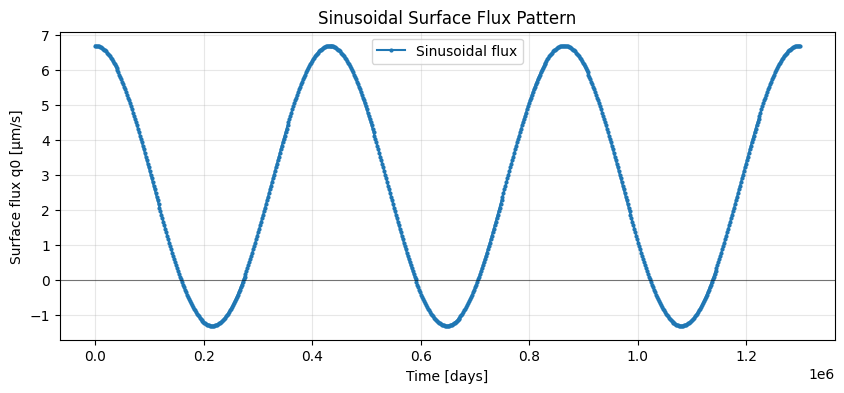

Flux range: -1.30 to 6.70 μm/s
Period: 5 days, Total duration: 15 days
722


In [523]:
def create_sinusoidal_qflux(total_days=15, dt_minutes=30,
                            amplitude=4e-6, period_days=5, 
                            mean_flux=1e-7, phase_shift=0):
    """
    Create sinusoidal surface flux pattern
    
    Parameters:
    - total_days: simulation duration
    - dt_minutes: time step in minutes
    - amplitude: amplitude of oscillation [m/s]
    - period_days: period of oscillation in days
    - mean_flux: mean flux level [m/s] (positive = evaporation, negative = infiltration)
    - phase_shift: phase shift in radians
    """
    dt_days = dt_minutes / (24*60)
    times = np.arange(0, total_days+dt_days, dt_days)

    # Sinusoidal flux: q(t) = mean + amplitude * sin(2π*t/period + phase)
    omega = 2 * np.pi / period_days  # angular frequency
    qflux = mean_flux + amplitude * np.sin(omega * times + phase_shift)
    times = times*86400

    return times, qflux

# Create sinusoidal q0_data
times_sin, qflux_sin = create_sinusoidal_qflux(
    total_days=15,
    amplitude=4e-6,      # 3 μm/s amplitude
    period_days=5,       # 5-day cycle
    mean_flux=7e-7,      # slight evaporation on average
    phase_shift=np.pi/2  # start at peak
)
qflux_sin = (qflux_sin+2e-6)
q0_data_sin = (times_sin.tolist(), qflux_sin.tolist())

# Plot the sinusoidal flux
plt.figure(figsize=(10,4))
plt.plot(times_sin, qflux_sin*1e6, '-o', ms=2, label='Sinusoidal flux')
plt.axhline(0, color='k', lw=0.8, alpha=0.5)
plt.xlabel("Time [days]")
plt.ylabel("Surface flux q0 [μm/s]")
plt.title("Sinusoidal Surface Flux Pattern")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print(f"Flux range: {qflux_sin.min()*1e6:.2f} to {qflux_sin.max()*1e6:.2f} μm/s")
print(f"Period: {5} days, Total duration: {15} days")
print(len(times))

In [524]:
soil_params = {
    'theta_s': 0.4,
    'theta_r': 0.1,
    'alpha': 0.005,
    'n': 1.3,
    'Ks': 1e-5,
    'l': 0.5
}
# Define network configurations
h_net_config = {'hidden_dim': 64, 'num_layers': 4}
zb_net_config = {'hidden_dim': 32, 'num_layers': 3}

# Test the new pool + batch training approach
print("Testing Pool + Batch Training with Boundary Focus")
print("="*60)

# Define network configurations
h_net_config_pool = {'hidden_dim': 64, 'num_layers': 4}
zb_net_config_pool = {'hidden_dim': 32, 'num_layers': 3}

# Train with pool + batch approach
model_pool, losses_pool, comps_pool = train_pinn_pool_batch_autoweight(
    soil_params=soil_params,
    q0_data=q0_data_sin,
    Sy=0.6,
    zr=0.5,
    h_net_config=h_net_config_pool,
    zb_net_config=zb_net_config_pool,
    n_epochs=15000,
    learning_rate=3e-3,
    zb_initial=0.5,
    weight_update_freq=100,
    weight_lr=0.1,
    use_initial_scales=True,
    # Pool + batch parameters
    cache_size=10000,  # Large cache pool
    batch_size=500,  # Small batch sampling
    resample_freq=200,  # Resample every 100 epochs
    boundary_ratio=0.7,  # 70% points near boundaries
    high_residual_ratio=0.3,  # 60% high residual points
    temperature=1.0,  # Temperature for softmax sampling
)

Testing Pool + Batch Training with Boundary Focus
Training for 15000 epochs | lr=0.003
Adaptive weighting: updating every 100 epochs
Pool + Batch: cache_size=10000, batch_size=500, resample_freq=200
Boundary ratio: 70.0%, High residual ratio: 30.0%
Time domain from q0: t∈[0.000, 1297800.000], z adaptive in [-z_b(t), 0]
Initial weights: {'pde': 100000000.0, 'surf': 10000000000.0, 'wt_head': 1.0, 'wt_kin': 1.0, 'ic_h': 1.0, 'ic_zb': 1.0}

[   1/15000]
  Losses: total=2.153e+00
    PDE=7.603e-15, Surf=1.682e-10
    WT(h)=1.352e-02, WT(kin)=2.782e-10
    IC(h)=4.392e-01, IC(zb)=1.820e-02
  Weighted Gradients (L2 norm):
    PDE=8.241e-07, Surf=2.095e-01
    WT(h)=4.648e-01, WT(kin)=5.881e-11
    IC(h)=2.324e+00, IC(zb)=2.737e-01
    Total=2.729e+00
  Current weights:
    pde: 1.000e+08
    surf: 1.000e+10
    wt_head: 1.000e+00
    wt_kin: 1.000e+00
    ic_h: 1.000e+00
    ic_zb: 1.000e+00
  Cache stats (epoch 0):
    Mean residual: 7.513e-08
    Max residual: 1.102e-07
    Std residual: 4.

In [573]:
def plot_comprehensive_results(model, q0_data, soil_params, n_t=200, n_z=100):
    """
    Comprehensive plotting with 5 subplots:
    1. h(z,t) 2D colormap from -zb to 0
    2. zb(t) time series
    3. h(-zb(t), t) time series (should be close to zero)
    4. q0_data vs simulated surface flux comparison
    5. Initial conditions: prescribed vs modeled
    """
    model.eval()

    # Get time range from q0_data
    t_min, t_max = min(q0_data[0]), max(q0_data[0])

    # Create time grid
    t_lin = torch.linspace(t_min, t_max, n_t).to(device)

    # Get water table depth over time
    with torch.no_grad():
        zb_vals = model.zb_net(t_lin.view(-1, 1)).cpu().numpy().flatten()

    # Create adaptive z grid (from deepest water table to surface)
    z_min = -np.max(zb_vals) - 0.5  # Add some buffer
    z_max = 0.0
    z_lin = torch.linspace(z_min, z_max, n_z).to(device)

    # Create meshgrid for h(z,t)
    T, Z = torch.meshgrid(t_lin, z_lin, indexing="ij")
    t_flat = T.reshape(-1, 1)
    z_flat = Z.reshape(-1, 1)

    # Compute h(z,t) over the grid
    with torch.no_grad():
        h_flat, _ = model(z_flat, t_flat)
    H = h_flat.reshape(n_t, n_z).cpu().numpy()

    # Mask out regions below water table (physically meaningless)
    # Only show h(z,t) where z >= -zb(t) (i.e., above water table)
    T_np = T.cpu().numpy()
    Z_np = Z.cpu().numpy()

    H_masked = H.copy()
    for i, t_val in enumerate(t_lin.cpu().numpy()):
        zb_at_t = zb_vals[i]  # water table depth at this time
        mask = Z_np[i, :] < -zb_at_t  # regions below water table
        H_masked[i, mask] = np.nan  # mask with NaN (appears as white/transparent)

    # Get surface head h(0,t)
    z_surface = torch.zeros(n_t, 1).to(device)
    t_surface = t_lin.view(-1, 1)
    with torch.no_grad():
        h_surface, _ = model(z_surface, t_surface)
    h_surface = h_surface.cpu().numpy().flatten()

    # Initial conditions
    t_ic = torch.tensor([t_min]).to(device).view(-1, 1)
    z_ic_range = torch.linspace(-1.0, 0.0, 50).to(device).view(-1, 1)

    # Prescribed IC: h(z,t0) = z + zb(t0)
    with torch.no_grad():
        zb_ic = model.zb_net(t_ic).cpu().numpy().item()
    h_ic_prescribed = -1 - z_ic_range.cpu().numpy().flatten() / zb_ic

    # Modeled IC
    t_ic_expanded = t_ic.expand(50, 1)
    with torch.no_grad():
        h_ic_modeled, _ = model(z_ic_range, t_ic_expanded)
    h_ic_modeled = h_ic_modeled.cpu().numpy().flatten()

    # Calculate h at water table: h(-zb(t), t) - should be close to zero
    z_wt = (-torch.tensor(zb_vals)).to(device).view(-1, 1)
    t_wt = t_lin.view(-1, 1)
    with torch.no_grad():
        h_at_wt, _ = model(z_wt, t_wt)
    h_at_wt = h_at_wt.cpu().numpy().flatten()

    # Create the 5-subplot figure
    fig, axs = plt.subplots(2, 3, figsize=(20, 10))
    fig.suptitle("PINN Results Analysis", fontsize=16, fontweight="bold")

    # Subplot 1: h(z,t) 2D colormap with water table overlay
    im1 = axs[0, 0].pcolormesh(
        T.cpu().numpy() / 86400, Z.cpu().numpy(), H_masked, shading="auto", cmap="viridis"
    )
    axs[0, 0].plot(
        t_lin.cpu().numpy() / 86400, -zb_vals, "r--", lw=2, label="Water table z_b(t)"
    )
    axs[0, 0].set_title("Pressure Head h(z,t)")
    axs[0, 0].set_xlabel("Time [days]")
    axs[0, 0].set_ylabel("Depth z [m]")
    axs[0, 0].set_ylim(-5, 0)  # Set explicit limits: surface (0) at top, -2m at bottom
    axs[0, 0].legend(loc="lower right")
    plt.colorbar(im1, ax=axs[0, 0], label="h [m]")

    # Subplot 2: zb(t) time series
    axs[0, 1].plot(t_lin.cpu().numpy() / 86400, zb_vals, "b-", lw=2)
    axs[0, 1].set_title("Water Table Depth z_b(t)")
    axs[0, 1].set_xlabel("Time [days]")
    axs[0, 1].set_ylabel("z_b [m] (positive downward)")
    axs[0, 1].grid(True, alpha=0.3)

    # Subplot 3: h(zb(t),t) - should be close to zero (water table boundary condition)
    axs[0, 2].plot(t_lin.cpu().numpy() / 86400, h_at_wt, "m-", lw=2, label="h(-zb(t), t)")
    axs[0, 2].axhline(0, color="k", lw=1, linestyle="--", alpha=0.7, label="h=0")
    axs[0, 2].set_title("Pressure Head at Water Table")
    axs[0, 2].set_xlabel("Time [days]")
    axs[0, 2].set_ylabel("h(-zb(t), t) [m]")
    axs[0, 2].grid(True, alpha=0.3)
    axs[0, 2].legend()

    
    # Subplot 4: q0_data vs simulated surface flux comparison
    # Calculate simulated surface flux q_surf at z=0
    z_surf_req = torch.zeros(n_t, 1, requires_grad=True).to(device)
    t_surf_req = t_lin.view(-1, 1).requires_grad_(True)

    # Calculate simulated surface flux with gradients
    h_surf_grad, _ = model(z_surf_req, t_surf_req)
    K_surf = model.soil.K(h_surf_grad)
    dh_dz_surf = torch.autograd.grad(h_surf_grad.sum(), z_surf_req, create_graph=True)[
        0
    ]
    q_surf_simulated = -K_surf * (dh_dz_surf + 1.0)
    q_surf_simulated = q_surf_simulated.detach().cpu().numpy().flatten()

    # Plot both fluxes
    axs[1, 0].plot(
        np.array(q0_data[0]) / 86400, np.array(q0_data[1]) * 1e6, "g-", lw=2, label="q0 (prescribed)"
    )
    axs[1, 0].plot(
        t_lin.cpu().numpy()/86400,
        q_surf_simulated * 1e6,
        "r--",
        lw=2,
        label="q_surf (simulated)",
    )
    axs[1, 0].set_xlabel("Time [days]")
    axs[1, 0].set_ylabel("Surface flux [μm/s]")
    axs[1, 0].set_title("Prescribed vs Simulated Surface Flux")
    axs[1, 0].grid(True, alpha=0.3)
    axs[1, 0].legend()

    # Subplot 5: Initial conditions comparison
    axs[1, 1].plot(
        h_ic_prescribed,
        z_ic_range.cpu().numpy().flatten(),
        "r--",
        lw=2,
        label="Prescribed IC: h = z + z_b(t0)",
    )
    axs[1, 1].plot(
        h_ic_modeled,
        z_ic_range.cpu().numpy().flatten(),
        "b-",
        lw=2,
        label="Modeled IC: h(z,t0)",
    )
    axs[1, 1].set_title("Initial Conditions Comparison")
    axs[1, 1].set_xlabel("Pressure head h [m]")
    axs[1, 1].set_ylabel("Depth z [m]")
    axs[1, 1].set_ylim(-1.0, 0.0)
    axs[1, 1].legend()
    axs[1, 1].grid(True, alpha=0.3)
    axs[1, 1].invert_yaxis()

    # Hide the unused subplot (bottom right)
    axs[1, 2].axis("off")

    plt.tight_layout()
    plt.show()

    # Print some summary statistics
    print("\nSummary Statistics:")
    print(f"Water table depth range: {zb_vals.min():.3f} to {zb_vals.max():.3f} m")
    print(f"Surface head range: {h_surface.min():.3f} to {h_surface.max():.3f} m")
    print(f"h(-zb(t), t) range: {h_at_wt.min():.6f} to {h_at_wt.max():.6f} m")
    print(f"Max |h(-zb(t), t)|: {np.max(np.abs(h_at_wt)):.6f} m (should be close to 0)")
    print(f"Max IC error: {np.max(np.abs(h_ic_modeled - h_ic_prescribed)):.6f} m")


# Plot the comprehensive results


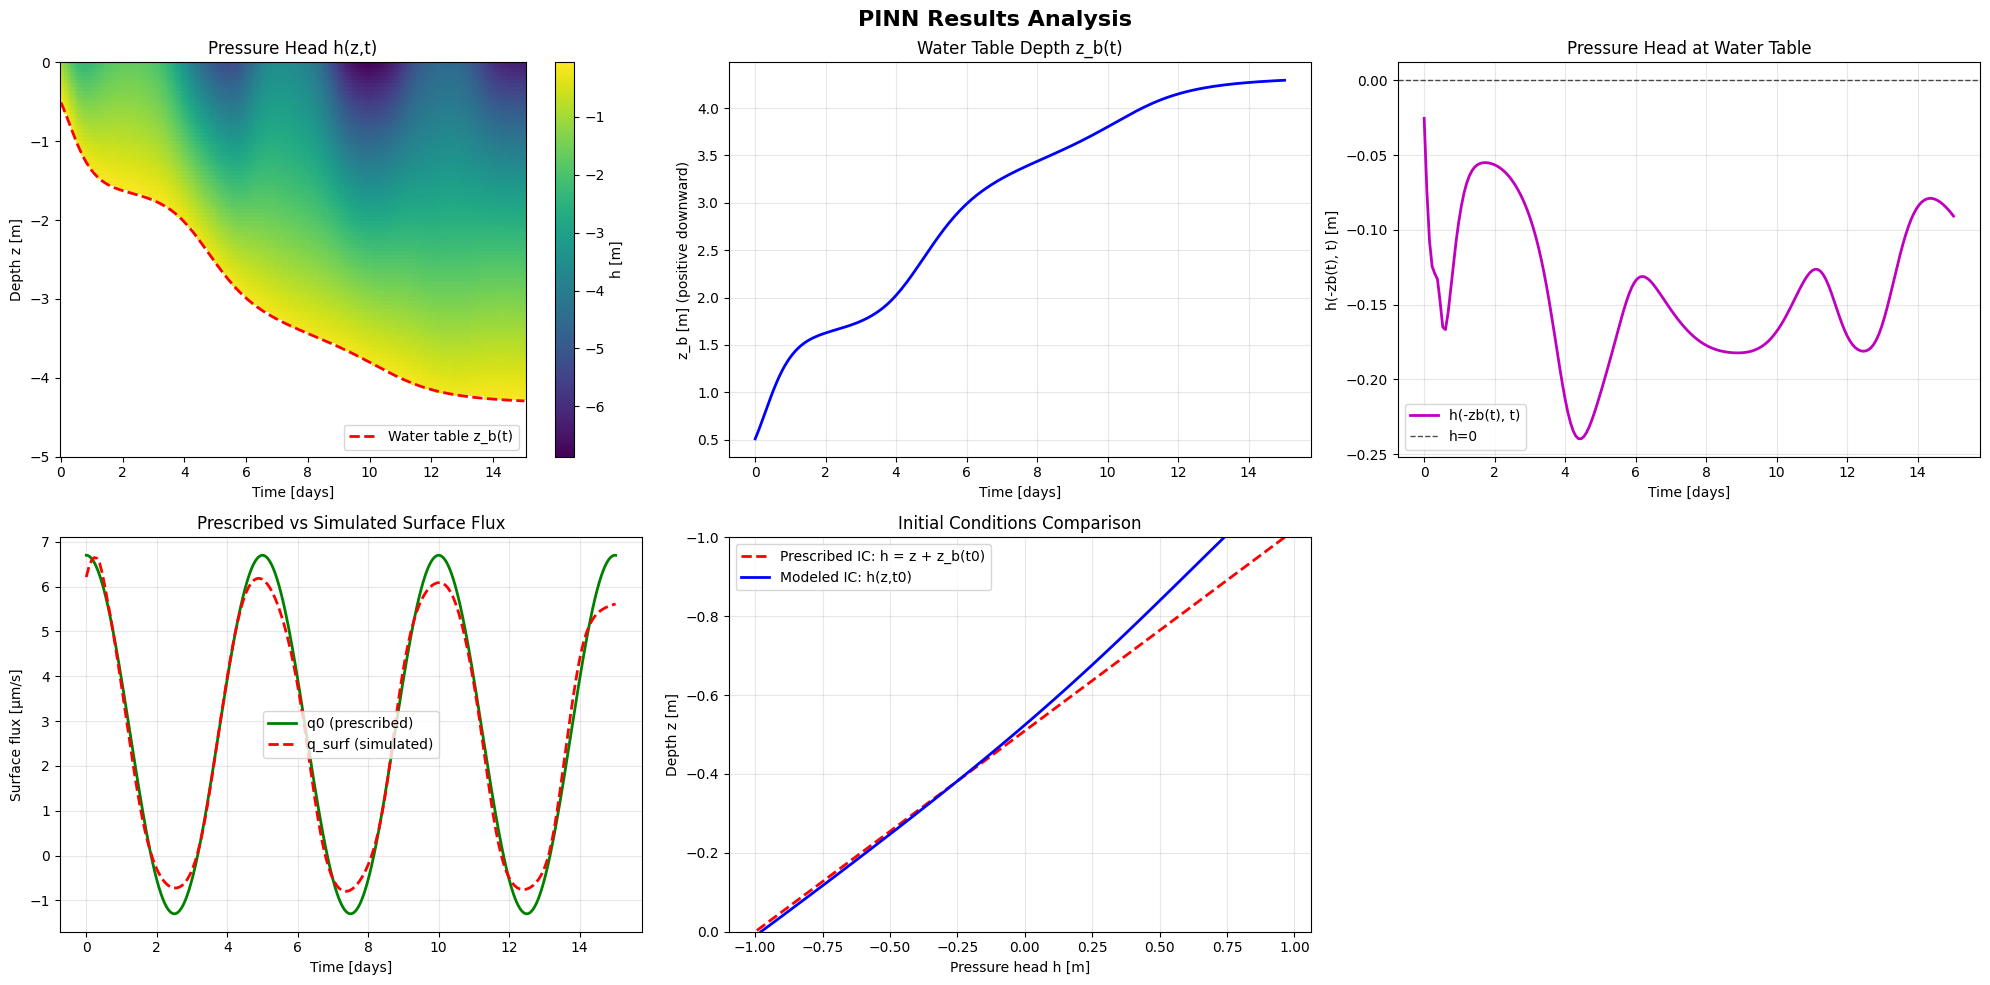


Summary Statistics:
Water table depth range: 0.509 to 4.293 m
Surface head range: -6.871 to -0.979 m
h(-zb(t), t) range: -0.239713 to -0.025440 m
Max |h(-zb(t), t)|: 0.239713 m (should be close to 0)
Max IC error: 0.223827 m


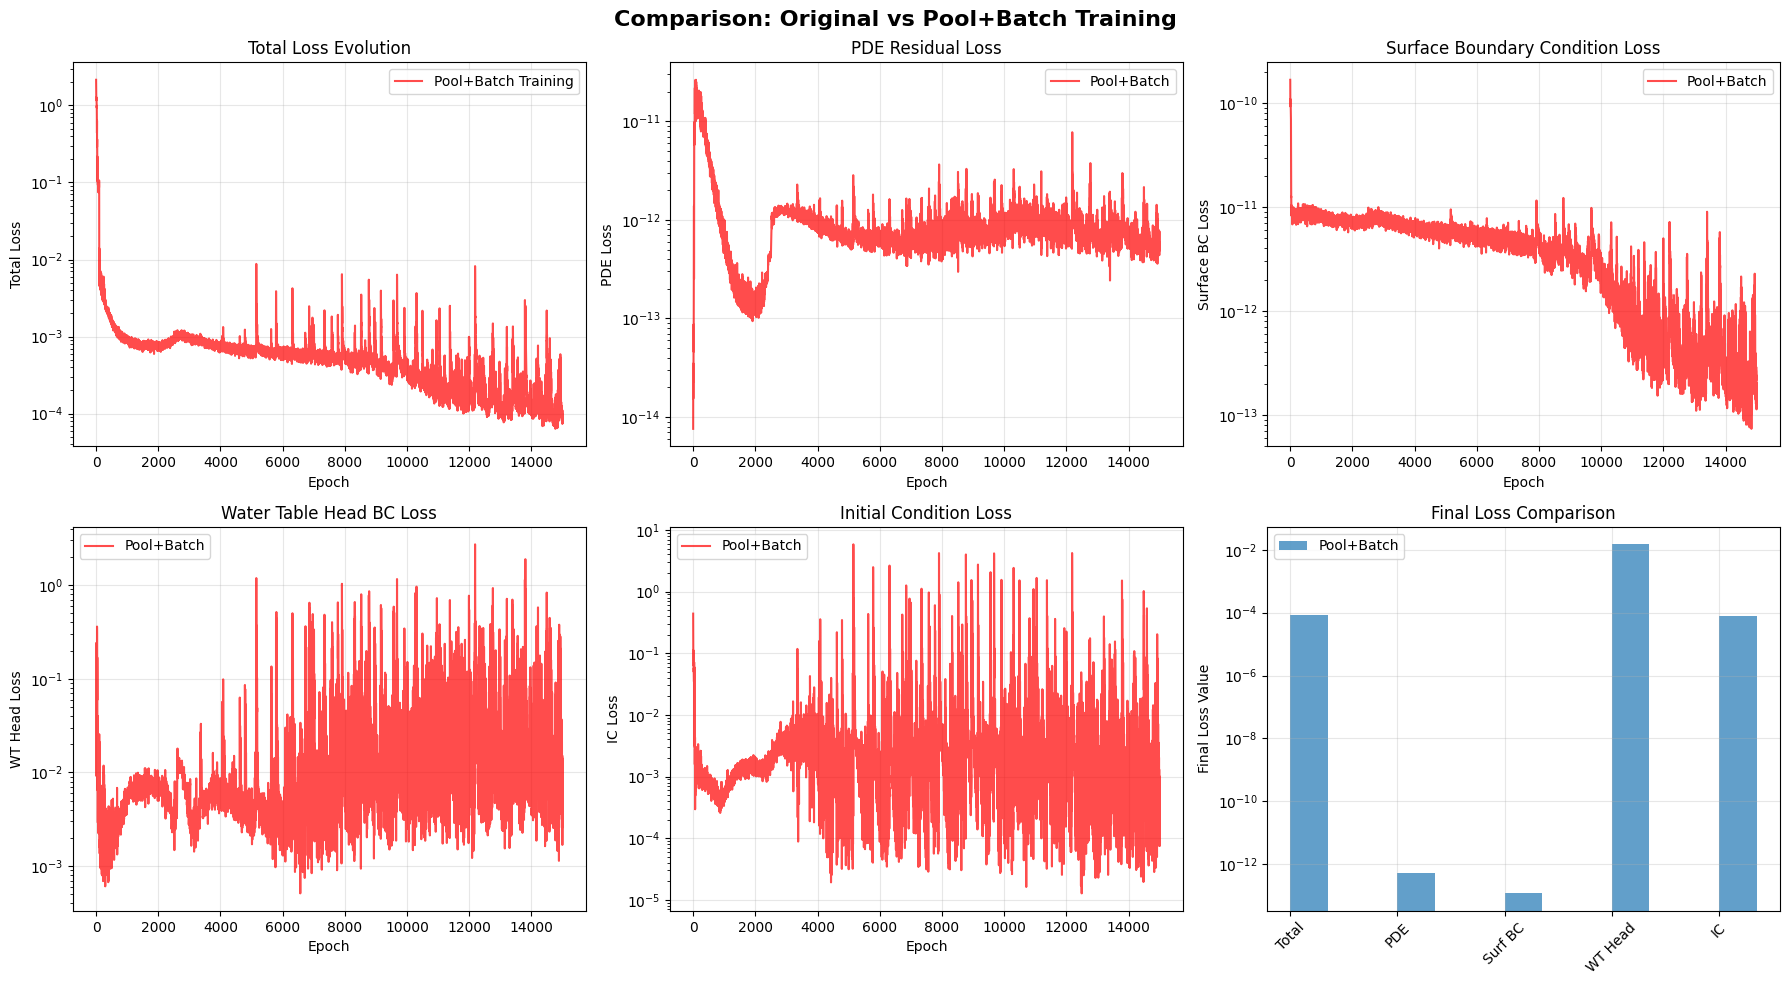

In [574]:
# Compare the two training approaches
import matplotlib.pyplot as plt


plot_comprehensive_results(model_pool, q0_data_sin, soil_params)


fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Comparison: Original vs Pool+Batch Training', fontsize=16, fontweight='bold')

# Plot 1: Total Loss Comparison
ax1 = axes[0, 0]
ax1.semilogy(losses_pool, 'r-', label='Pool+Batch Training', alpha=0.7)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Total Loss')
ax1.set_title('Total Loss Evolution')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: PDE Loss Comparison
ax2 = axes[0, 1]
ax2.semilogy(comps_pool['pde'], 'r-', label='Pool+Batch', alpha=0.7)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('PDE Loss')
ax2.set_title('PDE Residual Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Surface BC Loss Comparison
ax3 = axes[0, 2]
ax3.semilogy(comps_pool['surf'], 'r-', label='Pool+Batch', alpha=0.7)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Surface BC Loss')
ax3.set_title('Surface Boundary Condition Loss')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Water Table Head Loss Comparison
ax4 = axes[1, 0]
ax4.semilogy(comps_pool['wt_head'], 'r-', label='Pool+Batch', alpha=0.7)
ax4.set_xlabel('Epoch')
ax4.set_ylabel('WT Head Loss')
ax4.set_title('Water Table Head BC Loss')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Plot 5: Initial Condition Loss Comparison
ax5 = axes[1, 1]
ax5.semilogy(comps_pool['ic_h'], 'r-', label='Pool+Batch', alpha=0.7)
ax5.set_xlabel('Epoch')
ax5.set_ylabel('IC Loss')
ax5.set_title('Initial Condition Loss')
ax5.legend()
ax5.grid(True, alpha=0.3)


# Plot 6: Training Efficiency Summary
ax6 = axes[1, 2]
# Create bar plot comparing final losses
loss_names = ['Total', 'PDE', 'Surf BC', 'WT Head', 'IC']
pool_final = [losses_pool[-1], comps_pool['pde'][-1], comps_pool['surf'][-1], 
             comps_pool['wt_head'][-1], comps_pool['ic_h'][-1]]

x = np.arange(len(loss_names))
width = 0.35

bars2 = ax6.bar(x + width/2, pool_final, width, label='Pool+Batch', alpha=0.7)

ax6.set_ylabel('Final Loss Value')
ax6.set_title('Final Loss Comparison')
ax6.set_xticks(x)
ax6.set_xticklabels(loss_names, rotation=45)
ax6.legend()
ax6.set_yscale('log')
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

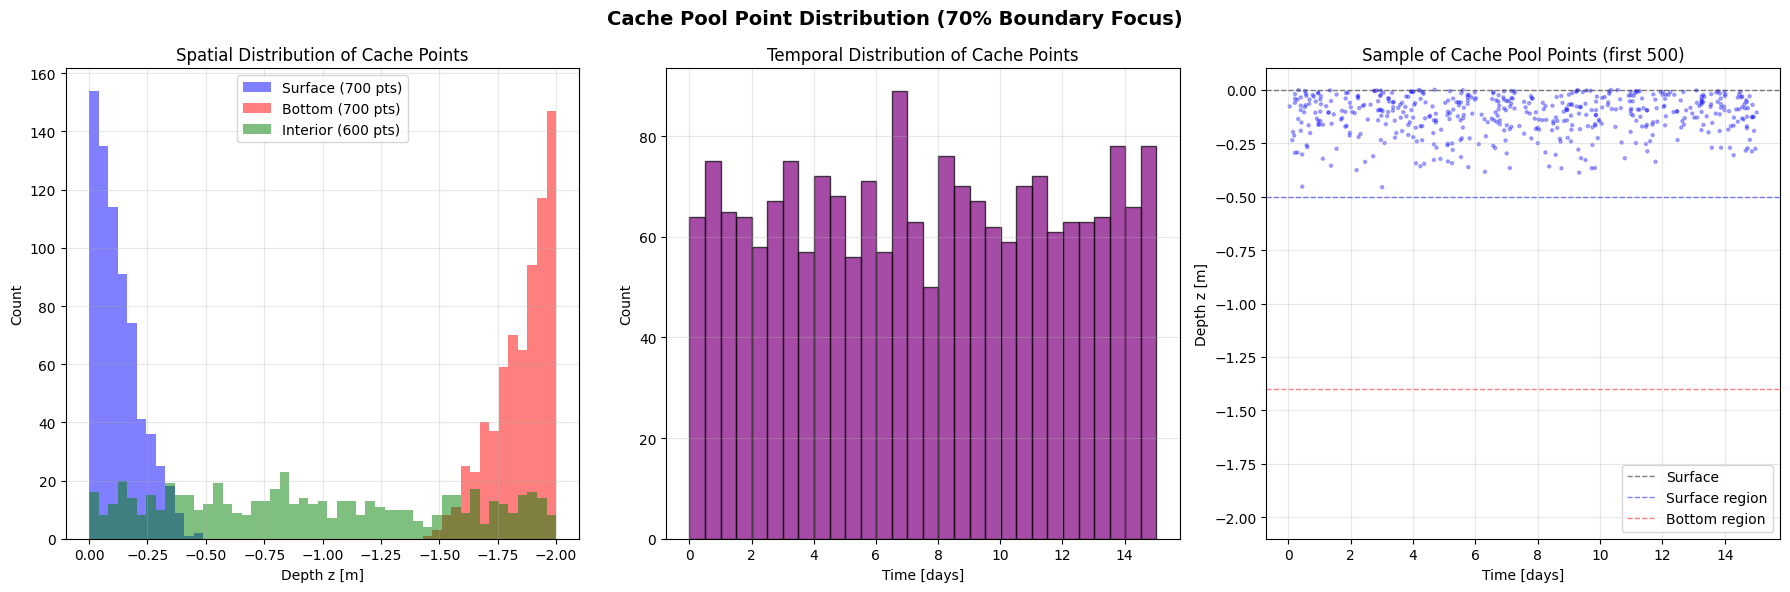


Cache Pool Statistics:
  Total points: 2000
  Boundary points: 1400 (70.0%)
    - Surface region: 700 (35.0%)
    - Bottom region: 700 (35.0%)
  Interior points: 600 (30.0%)


In [575]:
# Visualize the cache pool distribution
def visualize_cache_distribution():
    """Visualize how points are distributed in the cache pool"""
    
    # Generate a sample cache pool for visualization
    cache_size_vis = 2000
    
    # Use the same parameters as training
    boundary_ratio = 0.7
    t_max_vis = max(q0_data_sin[0])
    
    # Time sampling: half from q0_times, half random
    q0_times_t = torch.tensor(q0_data_sin[0], dtype=torch.float32, device=device)
    n_q0_sample = min(cache_size_vis // 2, len(q0_times_t))
    q0_indices = torch.randint(0, len(q0_times_t), (n_q0_sample,), device=device)
    t_from_q0 = q0_times_t[q0_indices].flatten()
    n_random = cache_size_vis - n_q0_sample
    t_random = torch.rand(n_random, device=device) * t_max_vis
    t_cache_vis = torch.cat([t_from_q0, t_random]).cpu().numpy()
    
    # Spatial sampling
    n_boundary = int(cache_size_vis * boundary_ratio)
    n_interior = cache_size_vis - n_boundary
    
    # Surface points
    n_surface = n_boundary // 2
    n_bottom = n_boundary - n_surface
    
    u_surface = torch.distributions.Beta(1.0, 3.0).sample((n_surface,)).to(device)
    z_surface = (-0.5 * u_surface).cpu().numpy()
    
    # Bottom points (assuming max depth around 2.0)
    max_zb = 2.0
    u_bottom = torch.distributions.Beta(3.0, 1.0).sample((n_bottom,)).to(device)
    z_bottom = (-max_zb * (0.7 + 0.3 * u_bottom)).cpu().numpy()
    
    # Interior points
    z_interior = (-max_zb * torch.rand(n_interior, device=device)).cpu().numpy()
    
    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Cache Pool Point Distribution (70% Boundary Focus)', fontsize=14, fontweight='bold')
    
    # Plot 1: Spatial distribution histogram
    ax1 = axes[0]
    bins = np.linspace(-max_zb, 0, 50)
    ax1.hist(z_surface, bins=bins, alpha=0.5, label=f'Surface ({len(z_surface)} pts)', color='blue')
    ax1.hist(z_bottom, bins=bins, alpha=0.5, label=f'Bottom ({len(z_bottom)} pts)', color='red')
    ax1.hist(z_interior, bins=bins, alpha=0.5, label=f'Interior ({len(z_interior)} pts)', color='green')
    ax1.set_xlabel('Depth z [m]')
    ax1.set_ylabel('Count')
    ax1.set_title('Spatial Distribution of Cache Points')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.invert_xaxis()  # Invert so surface (0) is on right
    
    # Plot 2: Time distribution
    ax2 = axes[1]
    ax2.hist(t_cache_vis / 86400, bins=30, alpha=0.7, color='purple', edgecolor='black')
    ax2.set_xlabel('Time [days]')
    ax2.set_ylabel('Count')
    ax2.set_title('Temporal Distribution of Cache Points')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: 2D scatter plot of cache points
    ax3 = axes[2]
    # Combine all z points
    z_all = np.concatenate([z_surface, z_bottom, z_interior])
    # Create corresponding time points (cycling through available times)
    t_sample = np.random.choice(t_cache_vis[:len(z_all)], size=len(z_all), replace=True)
    
    # Color by region
    colors = ['blue'] * len(z_surface) + ['red'] * len(z_bottom) + ['green'] * len(z_interior)
    ax3.scatter(t_sample[:500] / 86400, z_all[:500], c=colors[:500], alpha=0.3, s=5)
    ax3.set_xlabel('Time [days]')
    ax3.set_ylabel('Depth z [m]')
    ax3.set_title('Sample of Cache Pool Points (first 500)')
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(-max_zb - 0.1, 0.1)
    
    # Add horizontal lines for reference
    ax3.axhline(0, color='k', linestyle='--', linewidth=1, alpha=0.5, label='Surface')
    ax3.axhline(-0.5, color='b', linestyle='--', linewidth=1, alpha=0.5, label='Surface region')
    ax3.axhline(-max_zb * 0.7, color='r', linestyle='--', linewidth=1, alpha=0.5, label='Bottom region')
    ax3.legend(loc='lower right')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("\nCache Pool Statistics:")
    print(f"  Total points: {cache_size_vis}")
    print(f"  Boundary points: {n_boundary} ({boundary_ratio:.1%})")
    print(f"    - Surface region: {n_surface} ({n_surface/cache_size_vis:.1%})")
    print(f"    - Bottom region: {n_bottom} ({n_bottom/cache_size_vis:.1%})")
    print(f"  Interior points: {n_interior} ({n_interior/cache_size_vis:.1%})")

# Visualize the cache distribution
visualize_cache_distribution()
